In [46]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [47]:
#import models.qp as model # import get_stocks # 1/PBR + GP/A
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
import models.lu_zhang as model

importlib.reload(model)

<module 'models.lu_zhang' from '/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/quantitative-value/models/lu_zhang.py'>

In [48]:
MODEL_NAME = 'qp'
DATA_DIR = '../data/daily/8-1'

In [49]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [50]:
df_account

,start_date,end_date,filepath
0,2000-08-01,2001-08-01,../data/daily/8-1/2000-08-01.csv
1,2001-08-01,2002-08-01,../data/daily/8-1/2001-08-01.csv
2,2002-08-01,2003-08-01,../data/daily/8-1/2002-08-01.csv
3,2003-08-01,2004-08-02,../data/daily/8-1/2003-08-01.csv
4,2004-08-02,2005-08-01,../data/daily/8-1/2004-08-02.csv
5,2005-08-01,2006-08-01,../data/daily/8-1/2005-08-01.csv
6,2006-08-01,2007-08-01,../data/daily/8-1/2006-08-01.csv
7,2007-08-01,2008-08-01,../data/daily/8-1/2007-08-01.csv
8,2008-08-01,2009-08-03,../data/daily/8-1/2008-08-01.csv
9,2009-08-03,2010-08-02,../data/daily/8-1/2009-08-03.csv


In [51]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

2000-08-01 선정 기업 수 30
2001-08-01 선정 기업 수 30
2002-08-01 선정 기업 수 30
2003-08-01 선정 기업 수 30
2004-08-02 선정 기업 수 30
2005-08-01 선정 기업 수 30
2006-08-01 선정 기업 수 30
2007-08-01 선정 기업 수 30
2008-08-01 선정 기업 수 30
2009-08-03 선정 기업 수 30
2010-08-02 선정 기업 수 30
2011-08-01 선정 기업 수 30
2012-08-01 선정 기업 수 30
2013-08-01 선정 기업 수 30
2014-08-01 선정 기업 수 30
2015-08-03 선정 기업 수 30
2016-08-01 선정 기업 수 30
2017-08-01 선정 기업 수 30
2018-08-01 선정 기업 수 30


In [52]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2000-08-01 ~ 2001-08-01 : 1.6284248452876764
2001-08-01 ~ 2002-08-01 : 0.7717044550464961
2002-08-01 ~ 2003-08-01 : 0.8270470069362343
2003-08-01 ~ 2004-08-02 : 0.8012866722030929
2004-08-02 ~ 2005-08-01 : 2.3358786596900023
2005-08-01 ~ 2006-08-01 : 1.5167244417408754
2006-08-01 ~ 2007-08-01 : 1.9466531841217707
2007-08-01 ~ 2008-08-01 : 0.867680040599442
2008-08-01 ~ 2009-08-03 : 0.9935384752441974
2009-08-03 ~ 2010-08-02 : 1.4976732109277107
2010-08-02 ~ 2011-08-01 : 1.084753419306682
2011-08-01 ~ 2012-08-01 : 1.1907462368244637
2012-08-01 ~ 2013-08-01 : 1.3785148878772524
2013-08-01 ~ 2014-08-01 : 1.0275933826846246
2014-08-01 ~ 2015-08-03 : 1.4953901789625295
2015-08-03 ~ 2016-08-01 : 1.2014533396934077
2016-08-01 ~ 2017-08-01 : 1.0146006242697154
2017-08-01 ~ 2018-08-01 : 1.0412520165686978
2018-08-01 ~ 2019-08-01 : 0.9826067758001782


In [53]:
df_account['total'] = df_account['yield'].cumprod()

In [54]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [55]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [56]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [57]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

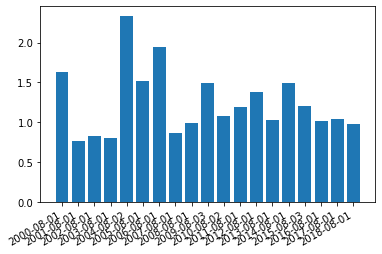

In [58]:
fig, ax = plt.subplots()
plt.bar(df_account['start_date'], df_account['yield'])
fig.autofmt_xdate()
plt.show()

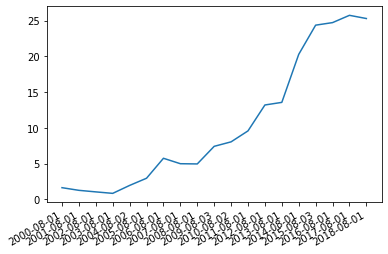

In [59]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [60]:
cagrs = df_account['cagr']
rolling_cagrs = []
ROLLING = 3
for i in range(len(cagrs)):
    if i - 3 < 0:
        rolling_cagr = np.mean(cagrs[0:i])
    else:
        rolling_cagr = np.mean(cagrs[i - 3:i])
    rolling_cagrs.append(rolling_cagr)

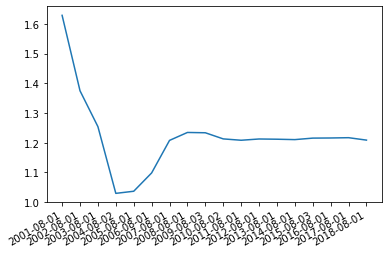

In [61]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], rolling_cagrs, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [62]:
1 - min(df_account['yield'])

0.2282955449535039

In [63]:
max(df_account['yield'])

2.3358786596900023

In [64]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
sum(df_account['delisted'])

11

In [65]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,delisted,delisted_stocks,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,2000-08-01,2001-08-01,../data/daily/8-1/2000-08-01.csv,"[036420, 012510, 008970, 005670, 000680, 01430...",1.628425,"[0.2, 1.0126582278481013, 1.6804979253112033, ...",0,[],1.628425,1.628425,0.766667,6.193248,0.072794,002250,033250
1,2001-08-01,2002-08-01,../data/daily/8-1/2001-08-01.csv,"[021050, 014130, 009470, 006580, 008420, 02691...",0.771704,"[0.9301745635910225, 0.6685633001422475, 0.922...",0,[],1.256663,1.121010,0.200000,1.709677,0.082528,017680,018310
2,2002-08-01,2003-08-01,../data/daily/8-1/2002-08-01.csv,"[044060, 017480, 036890, 005030, 031510, 04506...",0.827047,"[0.8947368421052632, 0.9733333333333334, 1.625...",0,[],1.039319,1.012938,0.233333,1.625731,0.084483,036890,012620
3,2003-08-01,2004-08-02,../data/daily/8-1/2003-08-01.csv,"[014130, 060250, 045300, 044060, 010040, 02691...",0.801287,"[1.8430717863105175, 0.5333333333333333, 0.726...",0,[],0.832793,0.955288,0.200000,2.220264,0.056426,016100,007770
4,2004-08-02,2005-08-01,../data/daily/8-1/2004-08-02.csv,"[024950, 064090, 065500, 038540, 051170, 05395...",2.335879,"[1.6883116883116882, 1.297709923664122, 1.4107...",0,[],1.945302,1.142345,1.000000,7.072626,1.214137,033790,010640
5,2005-08-01,2006-08-01,../data/daily/8-1/2005-08-01.csv,"[065620, 010600, 042500, 049480, 032960, 04980...",1.516724,"[0.8632478632478633, 2.183098591549296, 1.3906...",0,[],2.950488,1.197611,0.666667,4.478947,0.138418,046210,011700
6,2006-08-01,2007-08-01,../data/daily/8-1/2006-08-01.csv,"[006050, 081190, 004780, 066590, 011320, 01457...",1.946653,"[4.164893617021277, 0.9913793103448276, 1.8351...",0,[],5.743576,1.283674,0.933333,4.962963,0.926554,021040,066590
7,2007-08-01,2008-08-01,../data/daily/8-1/2007-08-01.csv,"[042500, 017370, 020400, 048830, 066670, 01150...",0.867680,"[0.6052631578947368, 0.5396825396825397, 0.535...",0,[],4.983586,1.222342,0.133333,6.250000,0.148438,001840,011500
8,2008-08-01,2009-08-03,../data/daily/8-1/2008-08-01.csv,"[081930, 042500, 080180, 012280, 094970, 03807...",0.993538,"[0.9787234042553191, 0.7342995169082126, 0.997...",0,[],4.951385,1.194516,0.266667,2.444976,0.230814,066670,005360
9,2009-08-03,2010-08-02,../data/daily/8-1/2009-08-03.csv,"[068330, 067170, 080180, 082260, 090470, 06662...",1.497673,"[3.759493670886076, 1.4792899408284024, 1.0352...",0,[],7.415557,1.221840,0.833333,3.931818,0.757432,089790,104040


In [24]:
#df_account.to_csv('log/' + MODEL_NAME + '-' + os.path.basename(DATA_DIR) + '.csv', index=False)